# Notebooks to merge subject information from imaging, clinical assessments and other sources of data
## Groups: 'PD', 'Prodromal', 'SWEDD', 'Control', 'Phantom', 'GenReg Unaff'

In [85]:
# from pathlib import Path
import sys
proj_path_str='/scratch/mr_proc'
sys.path.append(proj_path_str)
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
from private_libs.private_utils import report_visit

#PATH
main_dir = Path(proj_path_str)
data_dir = main_dir / 'tab_data' 
#out_dir = Path("/output")

#ppmi_dcm_file = data_dir / 'ppmi_dicomInfo.tsv'           # Inormation from dicom headers.
ppmi_img_dl_file = data_dir / 'PPMI_3T_sdMRI_3_07_2022.csv'  # Inormation from download database.
ppmi_moca_file  = data_dir / 'Montreal_Cognitive_Assessment__MoCA_.csv'  # Inormation from download database.
ppmi_updrs3_file  = data_dir / 'MDS_UPDRS_Part_III.csv'  # Inormation from download database.
ppmi_dicom_file = data_dir / 'PPMI_dicomInfo.tsv'  # Inormation from download database.


# Read tabular information
ppmi_img_dl_data  = pd.read_csv(ppmi_img_dl_file, sep=',')
ppmi_img_col_sel = ['Image Data ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit', 'Modality', 'Description']
# select imaging columns
ppmi_img_dl_data = ppmi_img_dl_data.loc[:, ppmi_img_col_sel].copy()
# select study groups
group_sel_list=['PD', 'Prodromal', 'SWEDD', 'Control']
ppmi_img_dl_data = ppmi_img_dl_data[ppmi_img_dl_data.Group.isin(group_sel_list)].copy()
# Get subject list and group information from imaging data
subject_group = ppmi_img_dl_data.loc[:, ['Subject','Group']].copy();
subject_group.groupby('Subject').agg(lambda x: set(x));
subject_group['Subject']=[int(x) for x in subject_group['Subject']]
# Get T1 and DTI data
sequence_str=['T1', 'MPRAGE', 'DTI']
ppmi_img_dl_data = ppmi_img_dl_data[(ppmi_img_dl_data['Description'].str.contains(sequence_str[0]))|(ppmi_img_dl_data['Description'].str.contains(sequence_str[1]))|(ppmi_img_dl_data['Description'].str.contains(sequence_str[2]))].copy()
# Get additional sequence information
protocol_seqs=ppmi_img_dl_data.Description.unique()

# read and select UPDRS-3data
ppmi_updrs3_data = pd.read_csv(ppmi_updrs3_file, sep=',')
updrs3_list= ['PATNO', 'EVENT_ID', 'NP3SPCH', 'NP3FACXP','NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR',
             'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR',
             'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT',
             'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR',
             'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'NP3TOT', 'NHY'];
other_updrs_list = ['DYSKPRES', 'DYSKIRAT'];
ppmi_updrs3_data=ppmi_updrs3_data.loc[:,updrs3_list].copy();

# read and select MOCA data
ppmi_moca_data   = pd.read_csv(ppmi_moca_file, sep=',')
moca_list= ['PATNO', 'EVENT_ID', 'MCAALTTM', 'MCACUBE', 'MCACLCKC', 'MCACLCKN', 'MCACLCKH', 'MCALION', 'MCARHINO',
            'MCACAMEL', 'MCAFDS', 'MCABDS', 'MCAVIGIL', 'MCASER7', 'MCASNTNC',
            'MCAVFNUM', 'MCAVF', 'MCAABSTR', 'MCAREC1', 'MCAREC2', 'MCAREC3',
            'MCAREC4', 'MCAREC5', 'MCADATE', 'MCAMONTH', 'MCAYR', 'MCADAY', 'MCAPLACE', 'MCACITY', 'MCATOT'];
ppmi_moca_data=ppmi_moca_data.loc[:,moca_list].copy();

## reading dicom header collection data
ppmi_dicom_data = pd.read_csv(ppmi_dicom_file, sep='\t')
#dicom_list = ['patient_id', 'patient_age', 'patient_sex', 'dim1', 'dim2', 'dim3', 'dim4', 'TR', 'TE', 'series_description', 'dcm_dir_name'];
#ppmi_dicom_data=ppmi_dicom_data.loc[:,dicom_list].copy()

/usr/local/miniconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (10,17,18,19,20,21,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## PPMI Converion: from dicom to BIDS niftis with HeuDiConv_0.9.0 

***Due to the limitation of number of inodes on CC, PPMI data is splited into PPMI_1.zip on Beluga and PPMI_2.zip on Narval, the data will be merged after conversion.***

    1. Extract all the dicoms in a folder named PPMI: '''unzip PPMI.zip -d ~/scratch/'''
    2. Correct studyID problems (takes hours to finish, put into subject paralellization next time): '''python studyID_fixer.py --data PPMI'''
    3. '''heudiconv_run1.sh PPMI''' + '''heudiconv_run1.format PPMI'''
    4. '''heudiconv_run2.sh PPMI all''' + '''heudiconv_run2.format PPMI'''
    5. Merge PPMI from Beluga nad Narval.

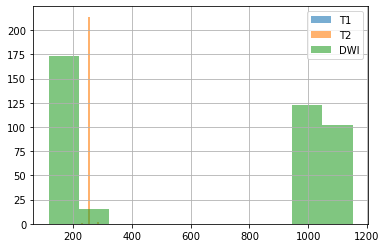

In [99]:
# the experiments on dicom header information includes find the exact field to filder the correct images, and check the dimentions of corresponding images.
# filter T1 with T1 or MPRAGE in series_description
from matplotlib import pyplot as plt 
ppmi_dicom_data[ppmi_dicom_data['series_description'].str.contains('T1|MPRAGE', regex=True)].dim1.hist(alpha=0.6, label='T1')
# filter T2 with T2 in series_description
ppmi_dicom_data[ppmi_dicom_data['series_description'].str.contains('T2')].dim1.hist(bins=10, alpha=0.6, label='T2')
# filter DTI with T1 in series_description
ppmi_dicom_data[ppmi_dicom_data['series_description'].str.contains('DTI')].dim1.hist(bins=10, alpha=0.6, label='DWI')
#plt.xlim([100,500])
plt.legend()

In [ ]:
['2D GRE-NM', '2D GRE-MT', 'AX GRE -MT', '2D GRE-NM_MT',
       'DTI_gated_ADC', 'DTI_gated', 'Sag MPRAGE GRAPPA',
       'MPRAGE GRAPPA2', 'Repeat DTI Sequence', 'MPRAGE GRAPPA 2',
       'Axial PD-T2 TSE FS', 'Axial PD-T2 TSE_AC PC line', 'DTI_LR',
       'AX DTI   L - R  (ROTATE AXIAL FOV 45 DEGREES)', 'AX DTI   L - R',
       'DTI Sequence', 'DTI_gated AC-PC LINE',
       'DTI_pulse gated_AC PC line', 'MPRAGE_GRAPPA',
       'MPRAGE_GRAPPA_ADNI', '3D T2 FLAIR', '2D DTI EPI FAT SHIFT RIGHT',
       'B0rf Map', '3D_Brain_VIEW_FLAIR_SAG', 'Axial DTI L>R',
       'LOWER 2D GRE MT', '3D T2 FLAIR_SAGITAL', 'DTI_LR_split_1',
       '3D T2  SPC FLAIR C9C1HN007', '3D T2 FLAIR_ND', 'AX DTI LR',
       'tra_T1_MPRAGE', 'DTI_ LR', '3D T2 FLAIR_ti1650', 'ep2d_diff_RL',
       'DTI_RL', 'SAG MPRAGE GRAPPA', 'DTI Sequence_FA', 'ep2d_diff_LR',
       'MPRAGE GRAPPA', 'AXIAL PD-T2 TSE FS', '2D GRE MT',
       'DTI Sequence_TRACEW', 'AXIAL 2D GRE-MT', 'MPRAGE ADNI',
       '3D SAG T1 MPRAGE', '3D_T2_FLAIR_SAG INVICCRO T2 FLAIR',
       'Sag 3D T2 FLAIR', 'DTI Sequence_ADC', 'SAG MPRAGE GRAPPA_ND',
       'Ax DTI', 'AX DTI   R - L', '3D T2 FLAIR_ti1650_ND',
       'SAG 3D FLAIR', 'DTI_30dir R-L', '2D DTI EPI FAT SHIFT LEFT',
       '2D GRE - MT', 'MPRAGE w/ GRAPPA', 'GRE B0', 'SAG CUBE FLAIR',
       'Axial DTI R>L', 'MPRAGE GRAPPA_ND', 'DTI_30dir L-R',
       'DTI_RL_split_1', 'Axial DTI FREQ A_P', 'AX DTI RL',
       'Axial PD-T2-FS TSE', '2D_GRE-MT', 'DTI_ RL',
       'Sag MPRAGE GRAPPA_ND', 'DTI_gated_FA', '3D T1',
       'T1-weighted, 3D VOLUMETRIC', 'SAG 3D T1 FSPGR',
       '3D SAG T1 MPRAGE_ND', '3D T1 MPRAGE', '3D_T2_FLAIR',
       'MPRAGE - Sag', '3D T1-weighted', 'SAG FSPGR 3D VOLUMETRIC T1',
       'DTI_gated_TRACEW']

In [95]:
ppmi_dicom_data[ppmi_dicom_data['series_description'].str.contains('T1|MPRAGE', regex=True)]

,total_files_till_now,example_dcm_file,series_id,dcm_dir_name,series_files,unspecified,dim1,dim2,dim3,dim4,...,study_description,referring_physician_name,series_description,sequence_name,image_type,accession_number,patient_age,patient_sex,date,series_uid
83,712,PPMI_75414_MR_Sag_MPRAGE_GRAPPA__br_raw_201902...,20-Sag MPRAGE GRAPPA,I1130190,176,NaN,256,240,176,1,...,(Current) PPMI PD STUDY VB17A V4 +RESTING^PD G...,NaN,Sag MPRAGE GRAPPA,*tfl3d1_ns,"('ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS3D', ...",None,073Y,F,20181213.0,2.16.124.113543.6006.99.05502924317893685853
84,712,PPMI_74158_MR_MPRAGE_GRAPPA2_br_raw_2019080912...,18-MPRAGE GRAPPA2,I1199284,176,NaN,256,240,176,1,...,(Current) PPMI PD STUDY VB17A V4 +RESTING^PD G...,NaN,MPRAGE GRAPPA2,*tfl3d1_ns,"('ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM')",None,063Y,F,20190103.0,2.16.124.113543.6006.99.4719221416753060806
86,712,PPMI_41829_MR_MPRAGE_GRAPPA_2__br_raw_20170907...,15-MPRAGE GRAPPA 2,I901280,176,NaN,256,240,176,1,...,MRI BRAIN W/O CONTRAST-PPMI-DR. ISAACSON,NaN,MPRAGE GRAPPA 2,*tfl3d1_ns,"('ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM')",None,000Y,M,20170130.0,2.16.124.113543.6006.99.0111566977545345908
169,658,PPMI_40922_MR_MPRAGE_GRAPPA_2__br_raw_20190205...,14-MPRAGE GRAPPA 2,I1044894,176,NaN,256,240,176,1,...,MRI BRAIN W/O CONTRAST-PPMI-DR. ISAACSON,NaN,MPRAGE GRAPPA 2,*tfl3d1_ns,"('ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM')",None,000Y,M,20180430.0,2.16.124.113543.6006.99.7387738991116723961
216,647,PPMI_75418_MR_MPRAGE_GRAPPA__br_raw_2020110617...,11-MPRAGE_GRAPPA,I1362236,176,NaN,256,256,176,1,...,MRI BRAIN WO IVCON,NaN,MPRAGE_GRAPPA,*tfl3d1_16ns,"('ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS3D', ...",None,058Y,F,20180920.0,2.16.124.113543.6006.99.1223694008777265534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,188,PPMI_101344_MR_SAG_FSPGR_3D_VOLUMETRIC_T1_br_r...,5-Anon,I1496465,188,NaN,256,256,188,1,...,None,NaN,SAG FSPGR 3D VOLUMETRIC T1,efgre3d,"('ORIGINAL', 'PRIMARY', 'OTHER')",12790061,000Y,NaN,20210813.0,2.16.124.113543.6006.99.04808325239876246095
1266,176,PPMI_74817_MR_MPRAGE_GRAPPA__br_raw_2021022311...,3-MPRAGE GRAPPA,I1412792,176,NaN,256,240,176,1,...,MRI BRAIN W/O CONTRAST-PPMI-DR. ISAACSON,NaN,MPRAGE GRAPPA,*tfl3d1_ns,"('ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS3D', ...",None,000Y,M,20180414.0,2.16.124.113543.6006.99.4937916786183503253
1267,176,PPMI_70347_MR_MPRAGE_GRAPPA2_br_raw_2019080914...,5-MPRAGE GRAPPA2,I1199401,176,NaN,256,240,176,1,...,RESEARCH^NEURO,NaN,MPRAGE GRAPPA2,*tfl3d1_16ns,"('ORIGINAL', 'PRIMARY', 'M', 'ND')",None,051Y,F,20190211.0,2.16.124.113543.6006.99.0450360208288660347
1268,176,PPMI_55468_MR_MPRAGE_GRAPPA2_br_raw_2019090912...,5-MPRAGE GRAPPA2,I1224324,176,NaN,256,240,176,1,...,RESEARCH^NEURO,NaN,MPRAGE GRAPPA2,*tfl3d1_16ns,"('ORIGINAL', 'PRIMARY', 'M', 'ND')",None,051Y,F,20190619.0,2.16.124.113543.6006.99.05176833054714064090


,patient_id,patient_age,patient_sex,dim1,dim2,dim3,dim4,TR,TE,series_description,dcm_dir_name
0,42457,051Y,F,448,448,16,1,0.498,3.37,2D GRE-NM,I1509996
1,42444,051Y,F,448,448,16,1,0.498,3.37,2D GRE-NM,I1525997
2,42443,063Y,M,448,448,16,1,0.498,3.37,2D GRE-MT,I1498290
3,42438,051Y,F,448,448,16,1,0.498,3.37,2D GRE-NM,I1525952
4,42429,051Y,F,448,448,16,1,0.498,3.37,2D GRE-NM,I1509980
...,...,...,...,...,...,...,...,...,...,...,...
1406,103809,036Y,M,1152,1152,33,1,10.000,80.00,DTI_RL,I1526189
1407,103183,057Y,M,1152,1152,33,1,10.100,83.00,DTI_RL,I1498878
1408,101738,067Y,M,1152,1152,33,1,10.100,83.00,DTI_RL,I1497646
1409,101516,070Y,F,1152,1152,33,1,10.000,80.00,DTI_RL,I1518950


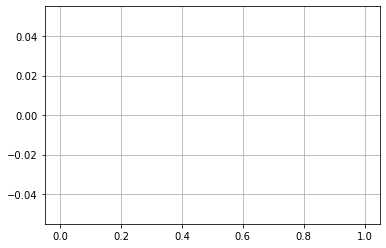

In [47]:
# images filter with series_description   

ppmi_dicom_data[ppmi_dicom_data['dcm_dir_name'].str.contains('DTI')].dim1.hist()
#'dim1', 'dim2', 'dim3', 'dim4', 'TR', 'TE', 'protocol_name'
ppmi_dicom_data

In [2]:
# reorganize PPMI Imaging data for easier query
tmp=ppmi_img_dl_data.groupby('Subject').agg(lambda x: list(x))
# get subject related features.
tmp['group'] = tmp['Group'].apply(lambda x: list(set(x))[0])
tmp['sex']   = tmp['Sex'].apply(lambda x: list(set(x))[0])
tmp['visit']  = tmp['Visit'].apply(lambda x: list(set(x)))
tmp['image_modality']  = tmp['Modality'].apply(lambda x: list(set(x)))
tmp['image_details'] =  tmp['Visit'].apply(lambda x: [str(y) for y in list(set(x))])
# get 
for x in tmp.index:
    tmp_str = ''
    for y in range(len(tmp.loc[x,'Visit'])):
        if y==0:
            tmp_str=str(tmp.loc[x,'Visit'][y])+'@'+str(tmp.loc[x,'Age'][y])+'@'+str(tmp.loc[x,'Modality'][y])+'@'+str(tmp.loc[x,'Image Data ID'][y])+'@'+str(tmp.loc[x,'Description'][y]);
        else:
            tmp_str=tmp_str+'+++'+str(tmp.loc[x,'Visit'][y])+'@'+str(tmp.loc[x,'Age'][y])+'@'+str(tmp.loc[x,'Modality'][y])+'@'+str(tmp.loc[x,'Image Data ID'][y])+'@'+str(tmp.loc[x,'Description'][y]);
    tmp.loc[x,'image_details']=tmp_str
ppmi_img_dl_data=tmp.drop(columns=['Image Data ID','Visit','Sex','Age','Group','Modality','Description'])

# subjects with MRI&DTI
tmp_imaging = ppmi_img_dl_data.copy()
tmp_imaging['filter_modality'] = tmp_imaging['image_modality'].apply(lambda x: x if len(x)>1 else np.nan).copy()
tmp_imaging=tmp_imaging.dropna()
tmp_imaging['img_visit']=tmp_imaging['visit']
tmp_imaging=tmp_imaging.drop(columns=['image_modality','image_details','filter_modality','visit'])

In [3]:
## preproc of tabular data
clinical_visit = ['BL', 'V04', 'V06', 'V08', 'V10', 'V12', 'V14', 'V15', 'V17', 'SC',
                  'V01', 'V02', 'V03', 'V05', 'V07', 'V09', 'V11', 'ST', 'V13',
                  'V16', 'PW', 'RS1', 'R17', 'R16', 'R15', 'V18', 'U01', 'R18',
                  'R14', 'R13', 'R08', 'R12', 'R06', 'R10', 'R04', 'R01'];
# visit: V01: 1,2,3    remote visit: R17:-17  Unscheduled visit: U01, -100
# screening:SC: -110 , RS1: rescreening, -111; RS2 rescreening, -112
# ST:Symptomatic Therapy -1000, 
# PW: Premature Withdrawal = -10000
unified_visit = [0, 4, 6, 8, 10, 12, 14, 15, 17, -110,
                 1, 2, 3, 5, 7, 9, 1, -1000, 13,
                 16, -10000, -111, -17, -16, -15, 18, -100, -18,
                 -14, -13, -8, -12, -6, -10, -4, -1];
visit_dict = dict(zip(clinical_visit, unified_visit))

# subjects with UPDRS
tmp_updrs3=ppmi_updrs3_data[['PATNO','EVENT_ID']].copy()
tmp_updrs3['Visit']=tmp_updrs3.EVENT_ID.apply(lambda x: visit_dict[x]);
tmp_updrs3=tmp_updrs3[tmp_updrs3['Visit']>0].copy(); tmp_updrs3['Subject']=tmp_updrs3['PATNO'];
tmp_updrs3 = tmp_updrs3.groupby('Subject').agg(lambda x: list(x)).copy()
tmp_updrs3['updrs3_visit']=tmp_updrs3['Visit'].apply(lambda x: list(set(x)))
tmp_updrs3=tmp_updrs3.drop(columns=['PATNO', 'EVENT_ID', 'Visit']).copy()
tmp_updrs3.index=[str(x) for x in tmp_updrs3.index]
# subjects with MOCA
tmp_moca = ppmi_moca_data
tmp_moca=ppmi_moca_data[['PATNO','EVENT_ID']].copy()
tmp_moca['Visit']=tmp_moca.EVENT_ID.apply(lambda x: visit_dict[x]);
tmp_moca=tmp_moca[tmp_moca['Visit']>0].copy(); tmp_moca['Subject']=tmp_moca['PATNO'];
tmp_moca = tmp_moca.groupby('Subject').agg(lambda x: list(x)).copy()
tmp_moca['moca_visit']=tmp_moca['Visit'].apply(lambda x: list(set(x)))
tmp_moca=tmp_moca.drop(columns=['PATNO', 'EVENT_ID', 'Visit']).copy()
tmp_moca.index=[str(x) for x in tmp_moca.index]

In [4]:
tmp_all=tmp_imaging.join([tmp_updrs3, tmp_moca], how='left');
tmp_all=tmp_all.dropna()
#print(tmp_all.img_visit)
#print(tmp_all.updrs3_visit)
#print(tmp_all.moca_visit)
tmp_all

,group,sex,img_visit,updrs3_visit,moca_visit
Subject,,,,,
14426,Prodromal,M,"[1, 7]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[8, 10, 4, 6]"
16644,Prodromal,M,"[1, 5, 7]","[1, 2, 3, 4, 6, 7, 8, 13]","[8, 4, 6]"
17608,Prodromal,M,[1],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]","[4, 6, 8, 10, 12, 13, 14]"
3101,SWEDD,M,"[1, 7]","[1, 2, 3, 4, 5, 6]","[4, 6]"
3102,PD,M,"[1, 21, 7]","[1, 2, 3, 5, 6, 7, 8, 9, 10]","[8, 10, 6]"
...,...,...,...,...,...
75512,Prodromal,F,[1],"[8, 2, 4, 6]","[8, 4]"
75525,Prodromal,F,[7],"[8, 6]","[8, 4, 6]"
75564,Prodromal,F,[1],"[2, 4, 6]","[4, 6]"


In [20]:
tmp_all_test=tmp_all.copy()
for x in tmp_all_test.index:
    tmp_=list(set.intersection(set(tmp_all_test.loc[x,'img_visit']),set(tmp_all_test.loc[x, 'updrs3_visit']),set(tmp_all_test.loc[x, 'moca_visit'])))
    if len(tmp_)==0:
        tmp_all_test.loc[x, 'visit_comm'] = np.nan;
    else:
        tmp_all_test.loc[x, 'visit_comm'] = [str(x) for x in tmp_]
tmp_all_test=tmp_all_test.dropna()
tmp_all_test

,group,sex,img_visit,updrs3_visit,moca_visit,visit_comm
Subject,,,,,,
85242,Prodromal,M,"[1, 5, 7]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]","[1, 4, 6, 8, 10, 12, 13, 14]",1
